In [ ]:
!pip install spmf

# Test example of AprioriRare via SPMF

In [36]:
!java -jar ../script/spmf.jar run AprioriRare rare_itemsets_input.txt rare_output.txt 60%

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 14
 The algorithm stopped at size 4, because there is no candidate
 Minimal rare itemsets count : 3
 Maximum memory usage : 10.457344055175781 mb
 Total time ~ 10 ms


In [62]:
!rm rare_output.txt rare_output.pkl rare_output.csv
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="rare_itemsets_input.txt",
    output_filename="rare_output.txt", arguments=['1%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("rare_output.csv")

rm: rare_output.pkl: No such file or directory
>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 24
 The algorithm stopped at size 5, because there is no candidate
 Minimal rare itemsets count : 1
 Maximum memory usage : 9.977325439453125 mb
 Total time ~ 7 ms

support extraction failed


In [63]:
spmf.to_pandas_dataframe()

support extraction failed


,pattern,sup
0,[],4


# Test examples on Circles data

In [1]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [2]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from importlib import reload

In [4]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [5]:
linscale_x = np.linspace(X[:,0].min(), X[:,0].max(), 11)
linscale_y = np.linspace(X[:,1].min(), X[:,1].max(), 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [6]:
min_support = 0.01
max_support = 0.8
min_delta_stability = 0.01

In [8]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

38


In [9]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/38 [00:00<?, ?it/s]

n extents 1729
CPU times: user 50.3 ms, sys: 11.6 ms, total: 61.9 ms
Wall time: 60.7 ms


In [48]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.8
sparse_extents = []
for i, extent in enumerate(stable_extents):
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

1729 735


In [40]:
anticoncepts_bas = [~ba for ba in csp.io.transpose_context(sparse_extents)]
anticoncepts_itemsets = [{i+1 for i in iset} for iset in csp.to_itemsets(anticoncepts_bas)[0]]

In [41]:
with open('anticoncepts_circles.basenum', 'w') as file:
    txt = '\n'.join([
        ' '.join(map(str, itemset)) if itemset else ''
        for itemset in anticoncepts_itemsets
    ])
    file.write(txt)

In [44]:
%%time
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="anticoncepts_circles.basenum",
    output_filename="clusterings_circles.txt", arguments=['80%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
#spmf.to_csv("clusterings_circles.csv")

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 75392
 The algorithm stopped at size 13, because there is no candidate
 Minimal rare itemsets count : 11094
 Maximum memory usage : 23.497024536132812 mb
 Total time ~ 3494 ms

CPU times: user 1.07 ms, sys: 6.1 ms, total: 7.17 ms
Wall time: 3.65 s


In [24]:
with open('clusterings_circles.txt', 'r') as file:
    lines = list(map(str.strip, file.readlines()))
    clusterings, supports = zip(*map(lambda x: str.split(x, '#SUP:'), lines))
    #clusterings = [frozenset(map(int, line.strip().split(' '))) for line in clusterings]
    clusterings = [frozenset([int(x)-1 for x in line.strip().split(' ')]) for line in clusterings]
    supports = [int(line.strip()) for line in supports]
print(len(clusterings), len(supports))

1164 1164


In [25]:
from functools import reduce
from bitarray import frozenbitarray

clusters_extents = [
    reduce(frozenbitarray.__or__, map(sparse_extents.__getitem__, idxs))
    for idxs in clusterings
]
assert ((np.array([x.count() for x in clusters_extents])+np.array(supports))==len(data)).all()

In [26]:
import pandas as pd

In [27]:
%%time
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data, min_support=0, max_support=2)
len(concepts_dict['extent'])

CPU times: user 20.2 ms, sys: 1.67 ms, total: 21.9 ms
Wall time: 21.1 ms


17

In [298]:
weight_params = dict(
    overlap_weight=0.2,
    n_concepts_weight=0.1,
    imbalance_weight=0.1,
    stability_weight=0.2,
    complexity_weight=0.1,
    n_concepts_max=10,
)
clusterings_dict = {
    idxs: clib.clustering_reward2(idxs, concepts_info=concepts_dict, **weight_params)[1]
    for idxs in clusterings
}
clusterings_df = pd.DataFrame(clusterings_dict).T

In [299]:
signs = np.array([1 if f in {'coverage', 'stability'} else -1 for f in clusterings_df])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df])

In [300]:
clusterings_df['reward'] = (clusterings_df*weights*signs).sum(1)

In [301]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)

In [302]:
clusterings_df

,coverage,overlap,n_concepts,imbalance,stability,complexity,reward
"(1, 2, 4, 5, 6, 7, 8, 10, 11)",0.820,0.048,0.9,0.015868,0.360000,1.0,0.690813
"(1, 2, 3, 4, 6, 7, 8, 10, 11)",0.820,0.048,0.9,0.015868,0.355556,1.0,0.689924
"(2, 3, 4, 5, 6, 7, 8, 10, 11)",0.810,0.056,0.9,0.015667,0.355556,1.0,0.678344
"(1, 2, 3, 5, 6, 7, 8, 10, 11)",0.808,0.060,0.9,0.015868,0.346667,1.0,0.673747
"(1, 2, 3, 4, 5, 6, 7, 8, 12)",0.810,0.060,0.9,0.023022,0.346667,1.0,0.675031
"(1, 2, 3, 4, 5, 6, 7, 8, 10)",0.848,0.064,0.9,0.010488,0.360000,1.0,0.716151
"(1, 2, 3, 4, 5, 6, 7, 8, 11)",0.832,0.064,0.9,0.014959,0.351111,1.0,0.697926
"(1, 2, 4, 5, 6, 7, 8, 9, 10)",0.824,0.064,0.9,0.011576,0.351111,1.0,0.690265
"(1, 2, 3, 5, 6, 7, 8, 9, 10)",0.822,0.066,0.9,0.011576,0.337778,1.0,0.685198
"(2, 3, 4, 5, 6, 7, 8, 9, 10)",0.820,0.066,0.9,0.011348,0.346667,1.0,0.684999


In [310]:
#best_clustering = clusterings_df.index[0]
best_clustering = clusterings_df.sort_values('overlap').index[0]
best_clustering = clusterings_df.sort_values('n_concepts').index[0]
concepts_df = pd.DataFrame(concepts_dict)

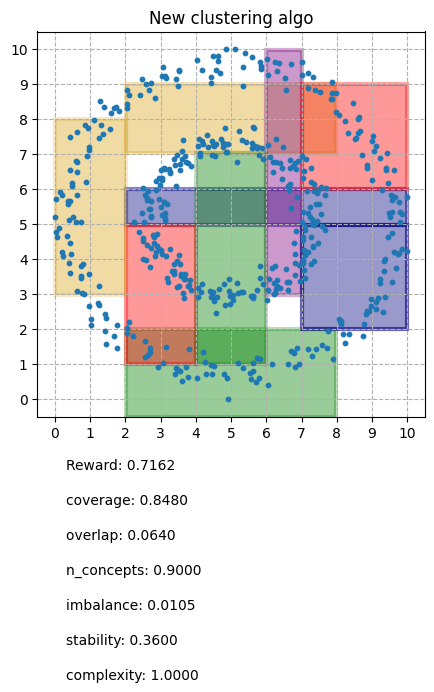

In [311]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(ax, f"New clustering algo", linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, best_clustering, concepts_df)

reward, reward_details = clib.clustering_reward2(best_clustering, concepts_df, **weight_params)
for i, (k, v) in enumerate([('Reward', reward)]+ list(reward_details.items())):
    ax.text(-1, linscale_y[0]-(i+2)*(linscale_y[1]-linscale_y[0]), f"{k}: {v:.4f}")


# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

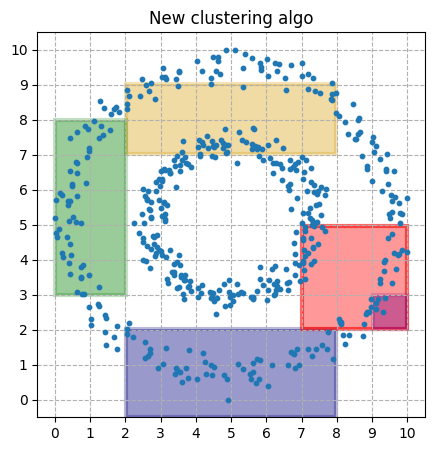

In [329]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(ax, f"New clustering algo", linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, [1,3,6,7,13], concepts_df)


# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()